# Analysing lipid membrane data

This Jupyter notebook demonstrates the utility of the *refnx* for:

 - the co-refinement of three contrast variation datasets of a DMPC (1,2-dimyristoyl-sn-glycero-3-phosphocholine) bilayer measured at the solid-liquid interface with a common model
 - the use of the `LipidLeaflet` component to parameterise the model in terms of physically relevant parameters
 - the use of Bayesian Markov Chain Monte Carlo (MCMC) to investigate the Posterior distribution of the curvefitting system.
 - the intrinsic usefulness of Jupyter notebooks to facilitate reproducible research in scientific data analysis

The first step in most Python scripts is to import modules and functions that are going to be used

In [1]:
# use matplotlib for plotting
%matplotlib inline
from importlib import resources
import matplotlib.pyplot as plt
import numpy as np

import refnx, scipy

# the analysis module contains the curvefitting engine
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective, process_chain

# the reflect module contains functionality relevant to reflectometry
from refnx.reflect import SLD, ReflectModel, Structure, LipidLeaflet

# the ReflectDataset object will contain the data
from refnx.dataset import ReflectDataset

In order for the analysis to be exactly reproducible the same package versions must be used. The *conda* packaging manager, and *pip*, can be used to ensure this is the case.

In [2]:
# version numbers used in this analysis
refnx.version.version, scipy.version.version

('0.1.53.dev0+19c4b26', '1.15.2')

The `ReflectDataset` class is used to represent a dataset. They can be constructed by supplying a filename

In [3]:
pth = resources.files(refnx.analysis)
data_d2o = ReflectDataset(pth / "tests" / "c_PLP0016596.dat")
data_d2o.name = "d2o"

data_hdmix = ReflectDataset(pth / "tests" / 'c_PLP0016601.dat')
data_hdmix.name = "hdmix"

data_h2o = ReflectDataset(pth / "tests" / 'c_PLP0016607.dat')
data_h2o.name = "h2o"

A `SLD` object is used to represent the Scattering Length Density of a material. It has `real` and `imag` attributes because the SLD is a complex number, with the imaginary part accounting for absorption. The units of SLD are $10^{-6} \mathring{A}^{-2}$

The `real` and `imag` attributes are `Parameter` objects. These `Parameter` objects contain the: parameter value, whether it allowed to vary, any interparameter constraints, and bounds applied to the parameter. The bounds applied to a parameter are probability distributions which encode the log-prior probability of the parameter having a certain value.

In [4]:
si = SLD(2.07 + 0j)
sio2 = SLD(3.47 + 0j)

# the following represent the solvent contrasts used in the experiment
d2o = SLD(6.36 + 0j)
h2o = SLD(-0.56 + 0j)
hdmix = SLD(2.07 + 0j)

# We want the `real` attribute parameter to vary in the analysis, and we want to apply
# uniform bounds. The `setp` method of a Parameter is a way of changing many aspects of
# Parameter behaviour at once.
d2o.real.setp(vary=True, bounds=(6.1, 6.36))
d2o.real.name='d2o SLD'

The `LipidLeaflet` class is used to describe a single lipid leaflet in our interfacial model. A leaflet consists of a head and tail group region. Since we are studying a bilayer then inner and outer `LipidLeaflet`'s are required.

In [5]:
# Parameter for the area per molecule each DMPC molecule occupies at the surface. We
# use the same area per molecule for the inner and outer leaflets.
apm = Parameter(56, 'area per molecule', vary=True, bounds=(52, 65))

# the sum of scattering lengths for the lipid head and tail in Angstrom.
b_heads = Parameter(6.01e-4, 'b_heads')
b_tails = Parameter(-2.92e-4, 'b_tails')

# the volume occupied by the head and tail groups in cubic Angstrom.
v_heads = Parameter(319, 'v_heads')
v_tails = Parameter(782, 'v_tails')

# the head and tail group thicknesses.
inner_head_thickness = Parameter(9, 'inner_head_thickness', vary=True, bounds=(4, 11))
outer_head_thickness = Parameter(9, 'outer_head_thickness', vary=True, bounds=(4, 11))
tail_thickness = Parameter(14, 'tail_thickness', vary=True, bounds=(10, 17))

# finally construct a `LipidLeaflet` object for the inner and outer leaflets.
# Note that here the inner and outer leaflets use the same area per molecule,
# same tail thickness, etc, but this is not necessary if the inner and outer
# leaflets are different.
inner_leaflet = LipidLeaflet(apm,
                             b_heads, v_heads, inner_head_thickness,
                             b_tails, v_tails, tail_thickness,
                             3, 3)

# we reverse the monolayer for the outer leaflet because the tail groups face upwards
outer_leaflet = LipidLeaflet(apm,
                             b_heads, v_heads, outer_head_thickness,
                             b_tails, v_tails, tail_thickness,
                             3, 0, reverse_monolayer=True)

The `Slab` Component represents a layer of uniform scattering length density of a given thickness in our interfacial model. Here we make `Slabs` from `SLD` objects, but other approaches are possible.

In [6]:
# Slab constructed from SLD object.
sio2_slab = sio2(15, 3)
sio2_slab.thick.setp(vary=True, bounds=(2, 30))
sio2_slab.thick.name = 'sio2 thickness'
sio2_slab.rough.setp(vary=True, bounds=(0, 7))
sio2_slab.rough.name = name='sio2 roughness'
sio2_slab.vfsolv.setp(0.1, vary=True, bounds=(0., 0.5))
sio2_slab.vfsolv.name = 'sio2 solvation'

solv_roughness = Parameter(3, 'bilayer/solvent roughness')
solv_roughness.setp(vary=True, bounds=(0, 5))

Once all the `Component`s have been constructed we can chain them together to compose a `Structure` object. The `Structure` object represents the interfacial structure of our system. We create different `Structure`s for each contrast. It is important to note that each of the `Structure`s share many components, such as the `LipidLeaflet` objects. This means that parameters used to construct those components are shared between all the `Structure`s, which enables co-refinement of multiple datasets. An alternate way to carry this out would be to apply constraints to underlying parameters, but this way is clearer. Note that the final component for each structure is a `Slab` created from the solvent `SLD`s, we give those slabs a zero thickness.

In [7]:
s_d2o = si | sio2_slab | inner_leaflet | outer_leaflet | d2o(0, solv_roughness)
s_hdmix = si | sio2_slab | inner_leaflet | outer_leaflet | hdmix(0, solv_roughness)
s_h2o = si | sio2_slab | inner_leaflet | outer_leaflet | h2o(0, solv_roughness)

The `Structure`s created in the previous step describe the interfacial structure, these structures are used to create `ReflectModel` objects that know how to apply resolution smearing, scaling factors and background.

In [8]:
model_d2o = ReflectModel(s_d2o)
model_hdmix = ReflectModel(s_hdmix)
model_h2o = ReflectModel(s_h2o)

model_d2o.scale.setp(vary=True, bounds=(0.9, 1.1))

model_d2o.bkg.setp(vary=True, bounds=(-1e-6, 1e-6))
model_hdmix.bkg.setp(vary=True, bounds=(-1e-6, 1e-6))
model_h2o.bkg.setp(vary=True, bounds=(-1e-6, 1e-6))

An `Objective` is constructed from a `ReflectDataset` and `ReflectModel`. Amongst other things `Objective`s can calculate chi-squared, log-likelihood probability, log-prior probability, etc. We then combine all the individual `Objective`s into a `GlobalObjective`.

In [9]:
objective_d2o = Objective(model_d2o, data_d2o)
objective_hdmix = Objective(model_hdmix, data_hdmix)
objective_h2o = Objective(model_h2o, data_h2o)

global_objective = GlobalObjective([objective_d2o, objective_hdmix, objective_h2o])

A `CurveFitter` object can perform least squares fitting, or MCMC sampling on the `Objective` used to construct it.

In [10]:
fitter = CurveFitter(global_objective)

We'll just do a normal least squares fit here. MCMC sampling is left as an exercise for the reader.

In [11]:
fitter.fit('differential_evolution');

-2743.7355775855553: : 70it [00:12,  5.84it/s]/Users/andrew/miniforge3/envs/dev3/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
-2743.7355775855553: : 70it [00:12,  5.67it/s]


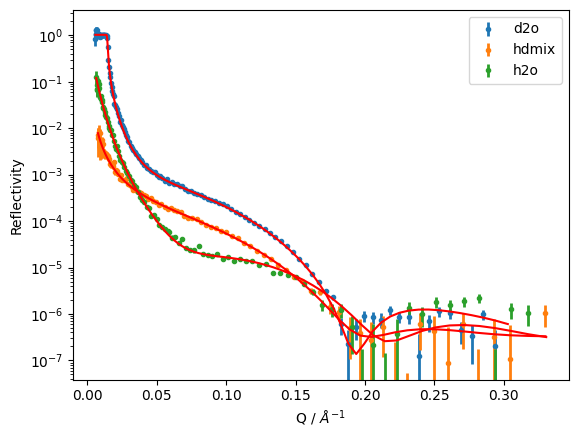

In [12]:
global_objective.plot()
plt.yscale('log')
plt.xlabel('Q / $\\AA^{-1}$')
plt.ylabel('Reflectivity')
plt.legend();

We can display out what the fit parameters are by printing out an objective:

In [13]:
print(global_objective)

________________________________________________________________________________


--Global Objective--
________________________________________________________________________________
Objective - 4884365728
Dataset = d2o
datapoints = 137
chi2 = 411.1660258149095
Weighted = True
Transform = None
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=1.0202 +/- 0.00356, bounds=[0.9, 1.1]>
<Parameter:     'bkg'     , value=-1.37525e-07 +/- 1.21e-07, bounds=[-1e-06, 1e-06]>
<Parameter:'dq - resolution', value=5  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
__________________________________________________________________________

Let's example the scattering length density profile for each of the systems:

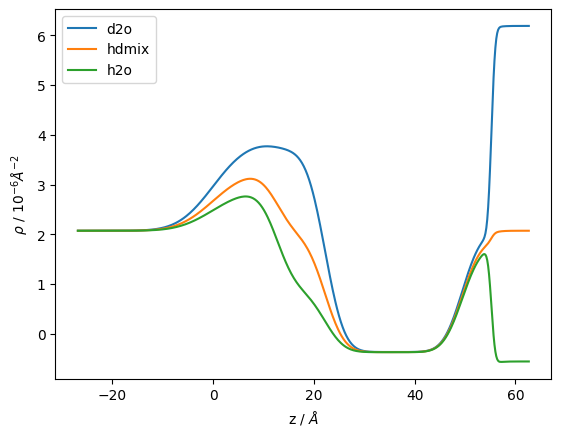

In [14]:
fig, ax = plt.subplots()
ax.plot(*s_d2o.sld_profile(), label='d2o')
ax.plot(*s_hdmix.sld_profile(), label='hdmix')
ax.plot(*s_h2o.sld_profile(), label='h2o')

ax.set_ylabel("$\\rho$ / $10^{-6} \\AA^{-2}$")
ax.set_xlabel("z / $\\AA$")
ax.legend();